<a href="https://colab.research.google.com/github/arthuremanuel/Artificial_Intelligence_Classes/blob/main/GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Problem description
* The primary goal is to transform landscape photographs into artworks in the impressionistic style of Claude Monet.

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        #print(os.path.join(dirname, filename))
        None

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

import matplotlib.pyplot as plt
import numpy as np

# Define image size
IMG_WIDTH = 256
IMG_HEIGHT = 256

In [ ]:
class InstanceNormalization(tf.keras.layers.Layer):
  """Custom Instance Normalization Layer."""

  def __init__(self, epsilon=1e-5):
    super(InstanceNormalization, self).__init__()
    self.epsilon = epsilon

  def build(self, input_shape):
    self.scale = self.add_weight(
        name='scale',
        shape=input_shape[-1:],
        initializer=tf.random_normal_initializer(1., 0.02),
        trainable=True)

    self.offset = self.add_weight(
        name='offset',
        shape=input_shape[-1:],
        initializer='zeros',
        trainable=True)

  def call(self, x):
    # Get mean and variance, keeping the 'channels' dimension.
    mean, variance = tf.nn.moments(x, axes=[1, 2], keepdims=True)
    inv = tf.math.rsqrt(variance + self.epsilon)
    normalized = (x - mean) * inv
    return self.scale * normalized + self.offset

# Exploratory Data Analysis

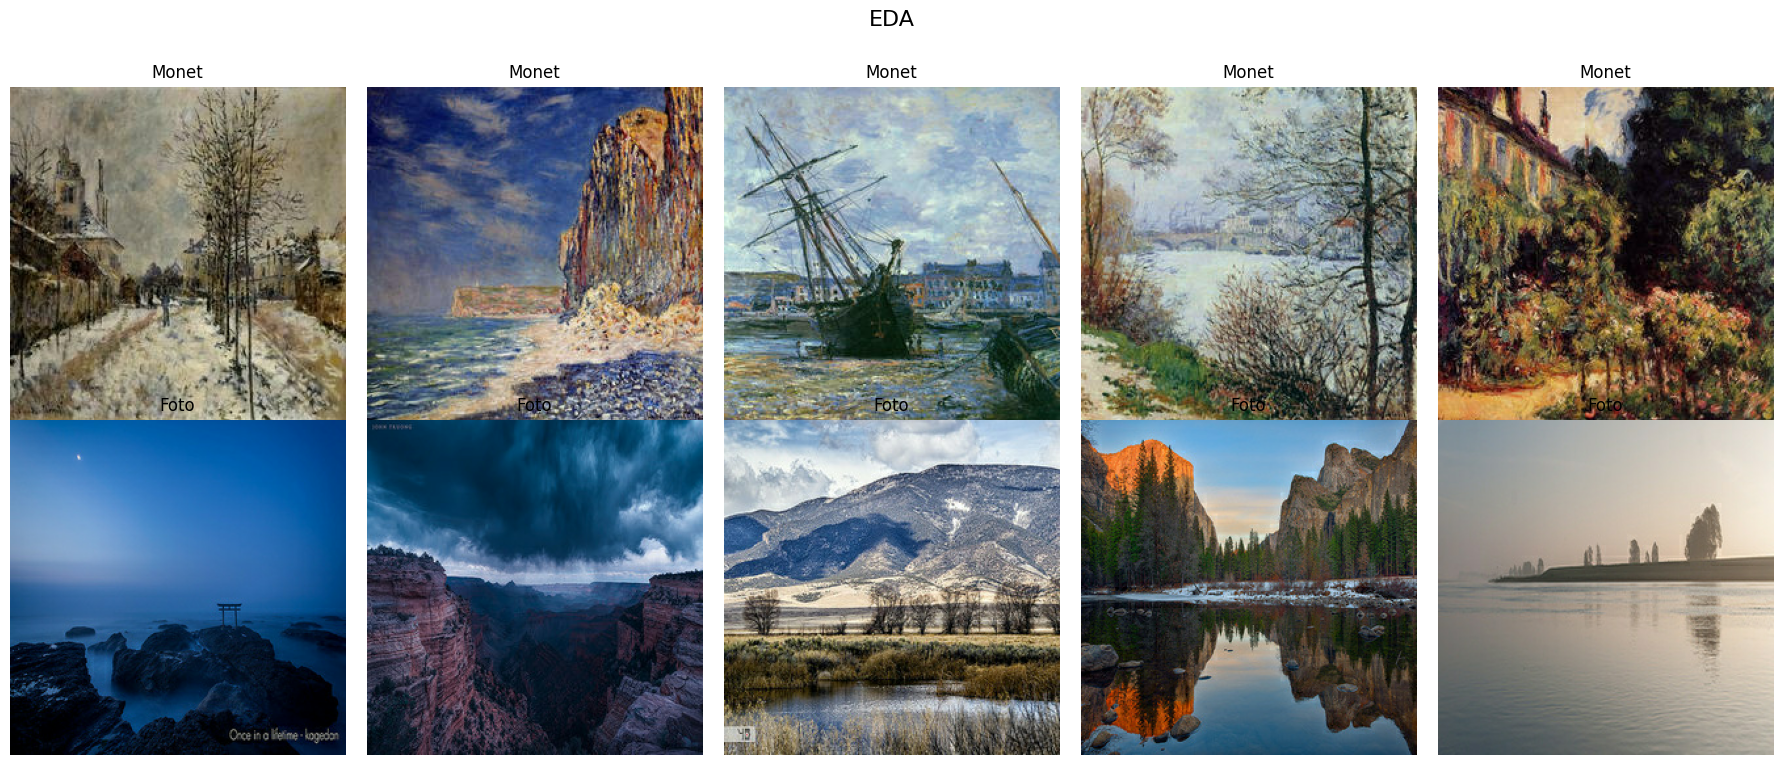

In [ ]:
import matplotlib.pyplot as plt

GCS_PATH_MONET = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
GCS_PATH_PHOTO = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')

sample_monet = load_dataset(GCS_PATH_MONET).take(5)
sample_photo = load_dataset(GCS_PATH_PHOTO).take(5)

plt.figure(figsize=(18, 8))

plt.suptitle("EDA", fontsize=16)

for i, image in enumerate(sample_monet):
    plt.subplot(2, 5, i + 1) # Linha 1
    plt.imshow(image)
    plt.title("Monet")
    plt.axis('off')

for i, image in enumerate(sample_photo):
    plt.subplot(2, 5, i + 6) # Linha 2
    plt.imshow(image)
    plt.title("Foto")
    plt.axis('off')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [ ]:
import tensorflow as tf
import numpy as np

monet_path = '/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec'
photo_path = '/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec'

monet_files = tf.io.gfile.glob(monet_path)
photo_files = tf.io.gfile.glob(photo_path)

print("--- Image Counts ---")
print(f"Monet Dataset: {len(monet_files)} TFRecord files")
print(f"Photo Dataset: {len(photo_files)} TFRecord files")
print("-" * 30)

if monet_files:
    sample_dataset = load_dataset(monet_files).take(1)

    for sample_image in sample_dataset:
        dimensions = sample_image.shape
        data_type = sample_image.dtype

        print("\n--- Image Characteristics ---")
        print(f"Dimensions (Height, Width, Channels): {dimensions}")
        print(f"Height: {dimensions[0]} pixels")
        print(f"Width: {dimensions[1]} pixels")
        print(f"Color Channels: {dimensions[2]} (3 = RGB)")
        print(f"Tensor Data Type: {data_type}")
        print("-" * 30)
else:
    print("\nCould not load a sample image because no files were found.")

--- Image Counts ---
Monet Dataset: 5 TFRecord files
Photo Dataset: 20 TFRecord files
------------------------------

--- Image Characteristics ---
Dimensions (Height, Width, Channels): (256, 256, 3)
Height: 256 pixels
Width: 256 pixels
Color Channels: 3 (3 = RGB)
Tensor Data Type: <dtype: 'float32'>
------------------------------


# Model
* CycleGAN: Consists of two Generators and two Discriminators.
* Generator G: Learns to transform Photos -> Monet paintings.
* Generator F: Learns to transform Monet paintings -> Photos.
* Cycle 1: Photo → Fake Monet → Reconstructed Photo
* Cycle 2: Monet → Fake Photo → Reconstructed Monet


**Generator (U-Net Architecture)**

In [ ]:
def downsample(filters, size, apply_instancenorm=True):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))
    if apply_instancenorm:
        result.add(InstanceNormalization())
    result.add(layers.LeakyReLU())
    return result

def upsample(filters, size, apply_dropout=False):
    initializer = tf.random_normal_initializer(0., 0.02)
    result = keras.Sequential()
    result.add(layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                      kernel_initializer=initializer, use_bias=False))
    result.add(InstanceNormalization())
    if apply_dropout:
        result.add(layers.Dropout(0.5))
    result.add(layers.ReLU())
    return result

def get_generator_model():
    """Builds the U-Net Generator Model"""
    inputs = layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3])

    # Encoder (Downsampling) path
    down_stack = [
        downsample(64, 4, apply_instancenorm=False), # (bs, 128, 128, 64)
        downsample(128, 4),                          # (bs, 64, 64, 128)
        downsample(256, 4),                          # (bs, 32, 32, 256)
        downsample(512, 4),                          # (bs, 16, 16, 512)
        downsample(512, 4),                          # (bs, 8, 8, 512)
        downsample(512, 4),                          # (bs, 4, 4, 512)
        downsample(512, 4),                          # (bs, 2, 2, 512)
        downsample(512, 4),                          # (bs, 1, 1, 512)
    ]

    # Decoder (Upsampling) path
    up_stack = [
        upsample(512, 4, apply_dropout=True),       # (bs, 2, 2, 1024)
        upsample(512, 4, apply_dropout=True),       # (bs, 4, 4, 1024)
        upsample(512, 4, apply_dropout=True),       # (bs, 8, 8, 1024)
        upsample(512, 4),                           # (bs, 16, 16, 1024)
        upsample(256, 4),                           # (bs, 32, 32, 512)
        upsample(128, 4),                           # (bs, 64, 64, 256)
        upsample(64, 4),                            # (bs, 128, 128, 128)
    ]

    initializer = tf.random_normal_initializer(0., 0.02)
    last = layers.Conv2DTranspose(3, 4, strides=2, padding='same',
                                  kernel_initializer=initializer,
                                  activation='tanh') # Output pixels in [-1, 1]

    x = inputs
    # Downsampling through the model & storing skip connections
    skips = []
    for down in down_stack:
        x = down(x)
        skips.append(x)

    skips = reversed(skips[:-1])

    # Upsampling and establishing the skip connections
    for up, skip in zip(up_stack, skips):
        x = up(x)
        x = layers.Concatenate()([x, skip])

    x = last(x)

    return keras.Model(inputs=inputs, outputs=x)

**Discriminator (PatchGAN Architecture)**

In [ ]:
def get_discriminator_model():
    """Builds the PatchGAN Discriminator Model"""
    initializer = tf.random_normal_initializer(0., 0.02)
    inp = layers.Input(shape=[IMG_WIDTH, IMG_HEIGHT, 3], name='input_image')

    # No instance norm in the first layer
    x = downsample(64, 4, False)(inp) # (bs, 128, 128, 64)
    x = downsample(128, 4)(x)        # (bs, 64, 64, 128)
    x = downsample(256, 4)(x)        # (bs, 32, 32, 256)

    # Adding a zero-padding layer
    x = layers.ZeroPadding2D()(x)    # (bs, 34, 34, 256)

    # Final convolution layer
    x = layers.Conv2D(512, 4, strides=1, kernel_initializer=initializer, use_bias=False)(x) # (bs, 31, 31, 512)
    x = InstanceNormalization()(x)
    x = layers.LeakyReLU()(x)
    x = layers.ZeroPadding2D()(x)    # (bs, 33, 33, 512)

    # Final output layer producing a 1-channel patch of predictions
    last = layers.Conv2D(1, 4, strides=1, kernel_initializer=initializer)(x) # (bs, 30, 30, 1)

    return tf.keras.Model(inputs=inp, outputs=last)

In [ ]:
class CycleGan(keras.Model):
    def __init__(self, monet_generator, photo_generator, monet_discriminator, photo_discriminator, lambda_cycle=10):
        super(CycleGan, self).__init__()
        self.m_gen = monet_generator
        self.p_gen = photo_generator
        self.m_disc = monet_discriminator
        self.p_disc = photo_discriminator
        self.lambda_cycle = lambda_cycle

    def compile(self, m_gen_optimizer, p_gen_optimizer, m_disc_optimizer, p_disc_optimizer, gen_loss_fn, disc_loss_fn, cycle_loss_fn, identity_loss_fn):
        super(CycleGan, self).compile()
        self.m_gen_optimizer = m_gen_optimizer
        self.p_gen_optimizer = p_gen_optimizer
        self.m_disc_optimizer = m_disc_optimizer
        self.p_disc_optimizer = p_disc_optimizer
        self.gen_loss_fn = gen_loss_fn
        self.disc_loss_fn = disc_loss_fn
        self.cycle_loss_fn = cycle_loss_fn
        self.identity_loss_fn = identity_loss_fn

    def train_step(self, batch_data):
        real_monet, real_photo = batch_data

        with tf.GradientTape(persistent=True) as tape:
            # --- Forward Pass ---
            # Generate fake images
            fake_photo = self.p_gen(real_monet, training=True)
            fake_monet = self.m_gen(real_photo, training=True)

            # Generate cycled images
            cycled_monet = self.m_gen(fake_photo, training=True)
            cycled_photo = self.p_gen(fake_monet, training=True)

            # Generate identity images
            same_monet = self.m_gen(real_monet, training=True)
            same_photo = self.p_gen(real_photo, training=True)

            # --- Discriminator Loss ---
            disc_real_monet = self.m_disc(real_monet, training=True)
            disc_fake_monet = self.m_disc(fake_monet, training=True)
            monet_disc_loss = self.disc_loss_fn(disc_real_monet, disc_fake_monet)

            disc_real_photo = self.p_disc(real_photo, training=True)
            disc_fake_photo = self.p_disc(fake_photo, training=True)
            photo_disc_loss = self.disc_loss_fn(disc_real_photo, disc_fake_photo)

            # --- Generator Loss ---
            # Adversarial loss
            monet_gen_loss = self.gen_loss_fn(disc_fake_monet)
            photo_gen_loss = self.gen_loss_fn(disc_fake_photo)

            # Cycle consistency loss
            total_cycle_loss = self.cycle_loss_fn(real_monet, cycled_monet, self.lambda_cycle) + \
                               self.cycle_loss_fn(real_photo, cycled_photo, self.lambda_cycle)

            # Identity loss
            monet_identity_loss = self.identity_loss_fn(real_monet, same_monet, self.lambda_cycle)
            photo_identity_loss = self.identity_loss_fn(real_photo, same_photo, self.lambda_cycle)

            # Total generator loss
            total_monet_gen_loss = monet_gen_loss + total_cycle_loss + monet_identity_loss
            total_photo_gen_loss = photo_gen_loss + total_cycle_loss + photo_identity_loss

        # --- Calculate and Apply Gradients ---
        monet_gen_grads = tape.gradient(total_monet_gen_loss, self.m_gen.trainable_variables)
        photo_gen_grads = tape.gradient(total_photo_gen_loss, self.p_gen.trainable_variables)
        monet_disc_grads = tape.gradient(monet_disc_loss, self.m_disc.trainable_variables)
        photo_disc_grads = tape.gradient(photo_disc_loss, self.p_disc.trainable_variables)

        # Apply gradients to optimizers
        self.m_gen_optimizer.apply_gradients(zip(monet_gen_grads, self.m_gen.trainable_variables))
        self.p_gen_optimizer.apply_gradients(zip(photo_gen_grads, self.p_gen.trainable_variables))
        self.m_disc_optimizer.apply_gradients(zip(monet_disc_grads, self.m_disc.trainable_variables))
        self.p_disc_optimizer.apply_gradients(zip(photo_disc_grads, self.p_disc.trainable_variables))

        return {
            "monet_gen_loss": total_monet_gen_loss,
            "photo_gen_loss": total_photo_gen_loss,
            "monet_disc_loss": monet_disc_loss,
            "photo_disc_loss": photo_disc_loss
        }

In [ ]:
# Instantiate the generators and discriminators
monet_generator = get_generator_model() # G: Photo -> Monet
photo_generator = get_generator_model() # F: Monet -> Photo

monet_discriminator = get_discriminator_model() # D_Y: Distinguishes real/fake Monets
photo_discriminator = get_discriminator_model() # D_X: Distinguishes real/fake Photos

# --- Define Loss Functions ---
def discriminator_loss(real, generated):
    real_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(real), real)
    generated_loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.zeros_like(generated), generated)
    return (real_loss + generated_loss) * 0.5

def generator_loss(generated):
    return tf.keras.losses.BinaryCrossentropy(from_logits=True)(tf.ones_like(generated), generated)

def calc_cycle_loss(real_image, cycled_image, lambda_val):
    loss1 = tf.reduce_mean(tf.abs(real_image - cycled_image))
    return lambda_val * loss1

def calc_identity_loss(real_image, same_image, lambda_val):
    loss = tf.reduce_mean(tf.abs(real_image - same_image))
    return lambda_val * 0.5 * loss

# --- Instantiate and Compile the Model ---
cycle_gan_model = CycleGan(
    monet_generator, photo_generator, monet_discriminator, photo_discriminator
)

cycle_gan_model.compile(
    m_gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_gen_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    m_disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    p_disc_optimizer=tf.keras.optimizers.Adam(2e-4, beta_1=0.5),
    gen_loss_fn=generator_loss,
    disc_loss_fn=discriminator_loss,
    cycle_loss_fn=calc_cycle_loss,
    identity_loss_fn=calc_identity_loss
)

cycle_gan_model.summary()

Model: "cycle_gan_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ functional_135 (Functional)     │ (None, 256, 256, 3)    │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_151 (Functional)     │ (None, 256, 256, 3)    │    54,414,979 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_155 (Functional)     │ (None, 30, 30, 1)      │     2,765,569 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ functional_159 (Functional)     │ (None, 30, 30, 1)      │     2,765,569 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 114,361,096 (436.25 MB)

 Trainable params: 114,361,096 (436.25 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
import re
import tensorflow as tf


AUTOTUNE = tf.data.AUTOTUNE

BUFFER_SIZE = 256
BATCH_SIZE = 1

GCS_PATH_MONET = tf.io.gfile.glob('/kaggle/input/gan-getting-started/monet_tfrec/*.tfrec')
GCS_PATH_PHOTO = tf.io.gfile.glob('/kaggle/input/gan-getting-started/photo_tfrec/*.tfrec')


def decode_image(image):
    """Decodes a JPEG image from a string."""
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [IMG_WIDTH, IMG_HEIGHT, 3])
    return image

def read_tfrecord(example):
    """Reads a TFRecord file and returns the image."""
    TFREC_FORMAT = {
        "image": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, TFREC_FORMAT)
    image = decode_image(example['image'])
    return image

def load_dataset(filenames, labeled=True, ordered=False):
    """Loads a dataset from TFRecord files."""
    dataset = tf.data.TFRecordDataset(filenames)
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_tfrecord, num_parallel_calls=AUTOTUNE)
    return dataset

def preprocess_image_train(image):
    """Normalizes images from [0, 1] to [-1, 1]."""
    return (image * 2) - 1

monet_ds = load_dataset(GCS_PATH_MONET, labeled=True).map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

photo_ds = load_dataset(GCS_PATH_PHOTO, labeled=True).map(
    preprocess_image_train, num_parallel_calls=AUTOTUNE).cache().prefetch(AUTOTUNE)

train_dataset = tf.data.Dataset.zip((monet_ds, photo_ds)) \
    .repeat() \
    .shuffle(BUFFER_SIZE) \
    .batch(BATCH_SIZE)

print("train_dataset created successfully!")
print(train_dataset)

train_dataset created successfully!
<_BatchDataset element_spec=(TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 256, 256, 3), dtype=tf.float32, name=None))>


In [ ]:
n_monet_images = len(GCS_PATH_MONET)

if n_monet_images == 0:
    raise ValueError("Error")

steps_per_epoch = n_monet_images // BATCH_SIZE

cycle_gan_model.fit(
    train_dataset,
    epochs=25,
    steps_per_epoch=steps_per_epoch
)

Epoch 1/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 105s 5s/step - monet_disc_loss: 1.1465 - monet_gen_loss: 11.0348 - photo_disc_loss: 1.1618 - photo_gen_loss: 11.2669
Epoch 2/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - monet_disc_loss: 0.8819 - monet_gen_loss: 9.9310 - photo_disc_loss: 0.9338 - photo_gen_loss: 10.6117
Epoch 3/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 27s 5s/step - monet_disc_loss: 0.7703 - monet_gen_loss: 8.8517 - photo_disc_loss: 0.7215 - photo_gen_loss: 8.9233
Epoch 4/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - monet_disc_loss: 0.8135 - monet_gen_loss: 9.2921 - photo_disc_loss: 0.8177 - photo_gen_loss: 9.3354
Epoch 5/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - monet_disc_loss: 0.7557 - monet_gen_loss: 8.2452 - photo_disc_loss: 0.6926 - photo_gen_loss: 8.1781
Epoch 6/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - monet_disc_loss: 0.7317 - monet_gen_loss: 5.7468 - photo_disc_loss: 0.7576 - photo_gen_loss: 5.8989
Epoch 7/25
5/5 ━━━━━━━━━━━━━━━━━━━━ 25s 5s/step - monet_disc_loss: 0.7370 - monet_gen_loss: 7.14

# Results

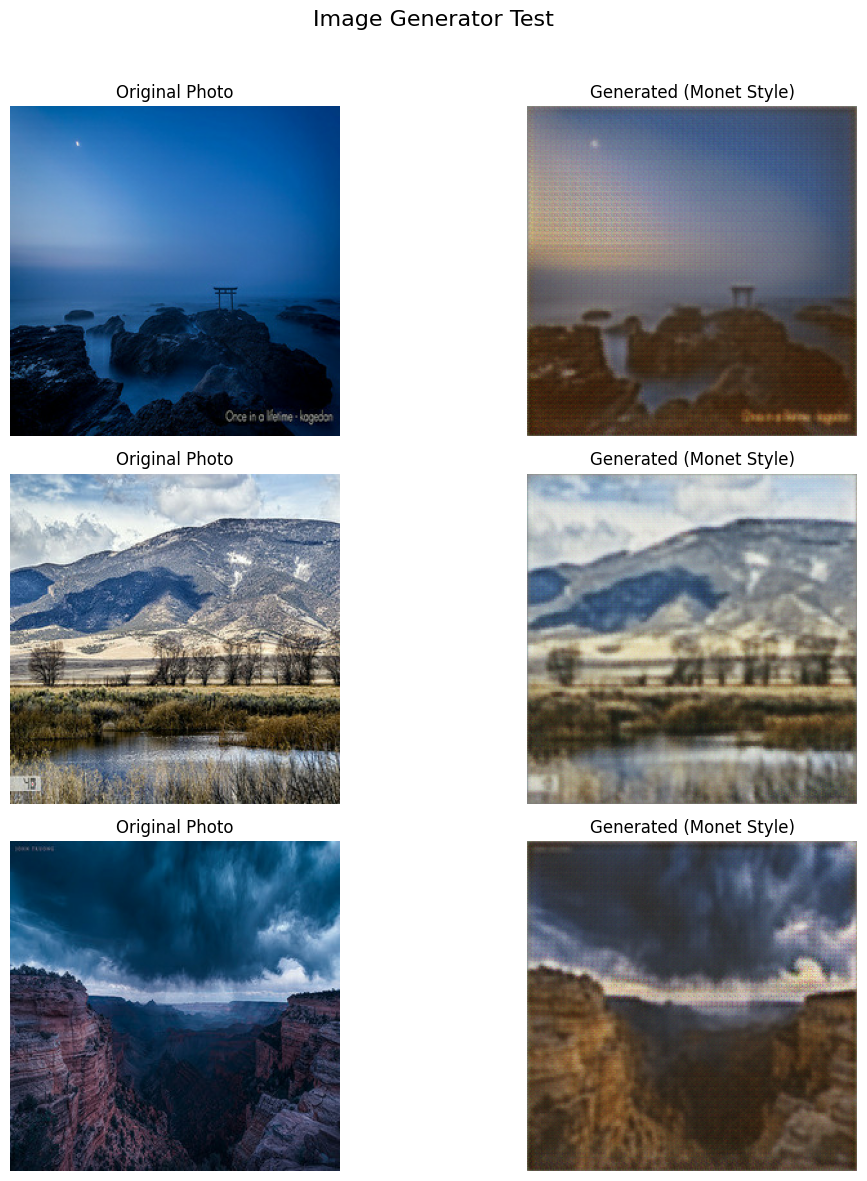

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np

def unnormalize(image):
    image_np = image.numpy()

    image_np = (image_np * 127.5 + 127.5)
    return image_np.astype(np.uint8)

test_photos = photo_ds.take(3)

plt.figure(figsize=(12, 12))
plt.suptitle("Image Generator Test", fontsize=16)

for i, photo_image in enumerate(test_photos):
    photo_batch = tf.expand_dims(photo_image, axis=0)
    generated_image_tensor = monet_generator(photo_batch, training=False)[0]

    original_photo_tensor = photo_image

    plt.subplot(3, 2, 2*i + 1)
    plt.title("Original Photo")
    plt.imshow(unnormalize(original_photo_tensor))
    plt.axis('off')

    plt.subplot(3, 2, 2*i + 2)
    plt.title("Generated (Monet Style)")
    plt.imshow(unnormalize(generated_image_tensor))
    plt.axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Conclusion

* This project demonstrated the implementation and training of a Cycle-Consistent Generative Adversarial Network (CycleGAN) for the task of artistic style transfer.
* The model proved capable of transforming standard photographs into new images that mimic Claude Monet.

# Submission

In [ ]:
import PIL
import os
import numpy as np

def unnormalize(image):
    """Converte a imagem do intervalo [-1, 1] para [0, 255]."""
    image = (image * 127.5 + 127.5)
    return image.astype(np.uint8)

PHOTO_PATH_FINAL = GCS_PATH_PHOTO

if not tf.io.gfile.glob(PHOTO_PATH_FINAL):
    raise ValueError(f"ERROR '{PHOTO_PATH_FINAL}'")
else:
    print(f"Sucess! {PHOTO_PATH_FINAL}")



SUBMISSION_DIR = "images"
if not os.path.exists(SUBMISSION_DIR):
    os.makedirs(SUBMISSION_DIR)

submission_ds = load_dataset(PHOTO_PATH_FINAL, ordered=True)
submission_ds = submission_ds.map(preprocess_image_train, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE)

image_count = 1
for photo_batch in submission_ds:
    generated_batch = monet_generator(photo_batch, training=False)
    for i in range(len(generated_batch)):
        prediction = generated_batch[i].numpy()
        prediction_unnormalized = unnormalize(prediction)

        image = PIL.Image.fromarray(prediction_unnormalized)
        image.save(f"{SUBMISSION_DIR}/{image_count}.jpg")
        image_count += 1

print(f"Done! {image_count - 1} images. Path: '{SUBMISSION_DIR}'.")

Sucess! ['/kaggle/input/gan-getting-started/photo_tfrec/photo12-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo11-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo05-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo08-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo18-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo06-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo17-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo10-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo09-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo15-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo04-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo19-350.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo02-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo16-352.tfrec', '/kaggle/input/gan-getting-started/photo_tfrec/photo0

In [ ]:
import shutil

shutil.make_archive('images', 'zip', SUBMISSION_DIR)

print("File 'images.zip' created!")

File 'images.zip' created!
